# 1. Install & import lib

In [ ]:
# !pip install imblearn scikit-plot mlflow
# !pip install eli5 shap 

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random

import joblib
import time, os
os.environ['TZ'] = 'Asia/Ho_Chi_Minh'
time.tzset()

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from collections import Counter
import missingno as msno

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.utils import resample

# from scikitplot.metrics import plot_roc
# from scikitplot.metrics import plot_precision_recall
# from scikitplot.metrics import plot_cumulative_gain
# from scikitplot.metrics import plot_lift_curve
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# import shap
# import eli5
# from eli5.sklearn import PermutationImportance

In [ ]:
import sklearn
sklearn.__version__

'1.0.2'

# 2. Data understanding & Data preparation

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:

MERCHANTDATA=pd.read_csv(r"/content/drive/MyDrive/BIDV/CARD_FRAUD/data/trainning/data_thang6.csv", error_bad_lines=False)
#MERCHANT_COLUMNS=MERCHANTDATA.columns.values.tolist();
MERCHANT_COLUMNS_PROPERTIES=pd.read_csv(r"/content/drive/MyDrive/BIDV/CARD_FRAUD/data/trainning/funix_num_feature_model_06_20210716-31032022.csv")
df_fraud_06 = pd.read_csv(r"/content/drive/MyDrive/BIDV/CARD_FRAUD/data/MERCHANT_KHONG.csv")


def get_list_columns():
    feature_cad = MERCHANT_COLUMNS_PROPERTIES.copy()
    feature_cad = feature_cad[(feature_cad["ORG_SOURCE"].isin(["CAD", "MIS_MRCH_DIM", "MIS_MR_CST_DIM","MIS_CST_FCT","MIS_MRCH_FCT","EXT"])) 
    & (feature_cad["USE_TO_MODEL"] == "Y")
    ]
    return feature_cad["COLUMN_NAME"].tolist()
    

def process_data_type(df):
    #xy ly kieu du lieu la date
    df["DAY_OPEN"]=pd.to_datetime(df["DAY_OPEN"])
    df["DAY_CLOSE"]=pd.to_datetime(df["DAY_CLOSE"])
    df["DAY_START"] = pd.to_datetime(df["DAY_START"])
    df["DAY_SUBM"] = pd.to_datetime(df["DAY_SUBM"])

    df["DAY_OPEN_YEAR"]=df["DAY_OPEN"].dt.year
    df["DAY_OPEN_MONTH"] = df["DAY_OPEN"].dt.month
    df["DAY_OPEN_DAY"] = df["DAY_OPEN"].dt.day

    df["DAY_CLOSE_YEAR"] = df["DAY_CLOSE"].dt.year
    df["DAY_CLOSE_MONTH"] = df["DAY_CLOSE"].dt.month
    df["DAY_CLOSE_DAY"] = df["DAY_CLOSE"].dt.day

    df["DAY_START_YEAR"] = df["DAY_START"].dt.year
    df["DAY_START_MONTH"] = df["DAY_START"].dt.month
    df["DAY_START_DAY"] = df["DAY_START"].dt.day

    df["DAY_SUBM_YEAR"] = df["DAY_SUBM"].dt.year
    df["DAY_SUBM_MONTH"] = df["DAY_SUBM"].dt.month
    df["DAY_SUBM_DAY"] = df["DAY_SUBM"].dt.day



    df=df.drop("DAY_CLOSE",1)
    df = df.drop("DAY_OPEN",1)
    df = df.drop("DAY_START", 1)
    df = df.drop("DAY_SUBM", 1)

    return df


In [ ]:
index_fraud = MERCHANTDATA['MERCHANT'].isin(df_fraud_06['MERCHANT'])
df_fraud = MERCHANTDATA[index_fraud]
df_fraud['MERCH_FR'] = 1 # FRAUD
df_non_fraud = MERCHANTDATA[~index_fraud]
df_non_fraud['MERCH_FR'] = 0

df_org = df_non_fraud.append(df_fraud)

df_fraud.shape 
df_non_fraud.shape
df_org.shape
MERCHANTDATA.shape

(752, 384)

(56710, 384)

(57462, 384)

(57462, 384)

# Exploratory Data Analysis

## Sumary dataframe

In [ ]:
df_org.shape

(57462, 384)

In [ ]:
df_org.head()

,MERCHANT,MER_TYPE,DAY_OPEN,DAY_CLOSE,BCARD_NBR,BRANCH,BUSNO_REGT,CLOSE_RSN,COMM_ACCT,CONTRACT,...,CST_NBR_OF_DAY_CIF,MSS_S,MSS_F,AVG_AMT,AVG_AMT_DAY,AMT,BIDV_ACCT_DEB,BIDV_ACCT_CRE,ISSUER_OTHER_TXN_NBR,HAS_TXN_LESS_15S
0,100463606,5411,2019-01-18,2099-12-31,UNKNOW,212,101122702,ACTIVE,,1965,...,896,0,0,0.0,0.0,0.0,0,0,0,0
1,100050319,5691,2012-09-12,2099-12-31,UNKNOW,122,104614685,ACTIVE,,244,...,3569,0,0,0.0,0.0,0.0,0,0,0,0
2,100379125,7011,2017-10-02,2019-05-09,UNKNOW,760,8027616,C,76010000801665,1601,...,2067,0,0,0.0,0.0,0.0,0,0,0,0
3,100419925,7011,2018-04-19,2099-12-31,UNKNOW,760,3502293098,ACTIVE,,1969,...,3932,0,0,0.0,0.0,0.0,0,0,0,0
4,100530567,7999,2020-05-06,2099-12-31,UNKNOW,702,1601067547,ACTIVE,,1957,...,3974,0,0,0.0,0.0,0.0,0,0,0,0


In [ ]:
df_org.isnull().sum()

MERCHANT                0
MER_TYPE                0
DAY_OPEN                0
DAY_CLOSE               0
BCARD_NBR               0
                       ..
AMT                     0
BIDV_ACCT_DEB           0
BIDV_ACCT_CRE           0
ISSUER_OTHER_TXN_NBR    0
HAS_TXN_LESS_15S        0
Length: 384, dtype: int64

In [ ]:
object_cols = df_org.select_dtypes(include='object').columns.to_list()
num_cols = df_org.select_dtypes(include='number').columns.to_list()
print(len(object_cols))
print(len(num_cols))

44
340


In [ ]:
df_org["MERCH_FR"].value_counts()

0    56710
1      752
Name: MERCH_FR, dtype: int64

<Figure size 720x504 with 0 Axes>

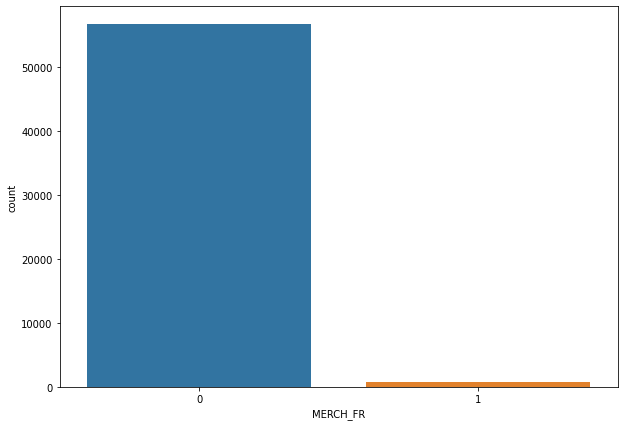

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.countplot(df_org["MERCH_FR"])

['END_STM_MTH', 'DEP_ACCT', 'SHORT_DEF', 'NUM_OF_TERM', 'PLC_OF_ISSU']


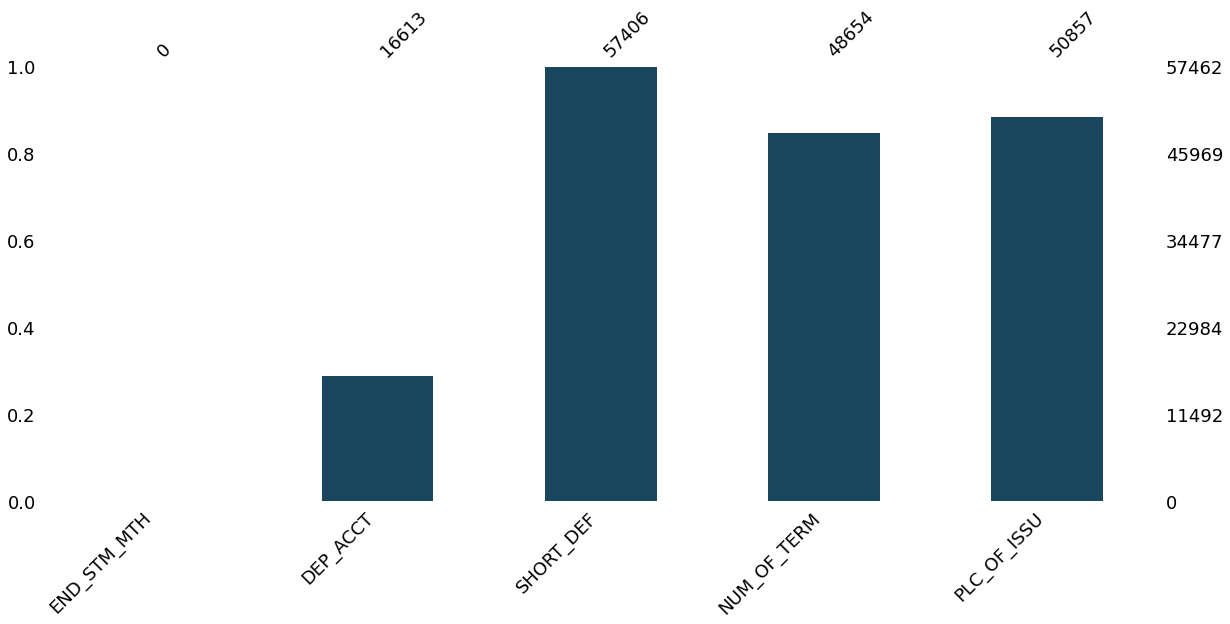

In [ ]:
# coulum with missing values
cols_missing_val = df_org.columns[df_org.isnull().any()].tolist()
print(cols_missing_val)

msno.bar(df_org[cols_missing_val],figsize=(20,8),color="#19455e",fontsize=18,labels=True)

In [ ]:
limitPer = len(df_org) * .50
df1 = df_org.dropna(thresh=limitPer, axis=1)

['SHORT_DEF', 'NUM_OF_TERM', 'PLC_OF_ISSU']


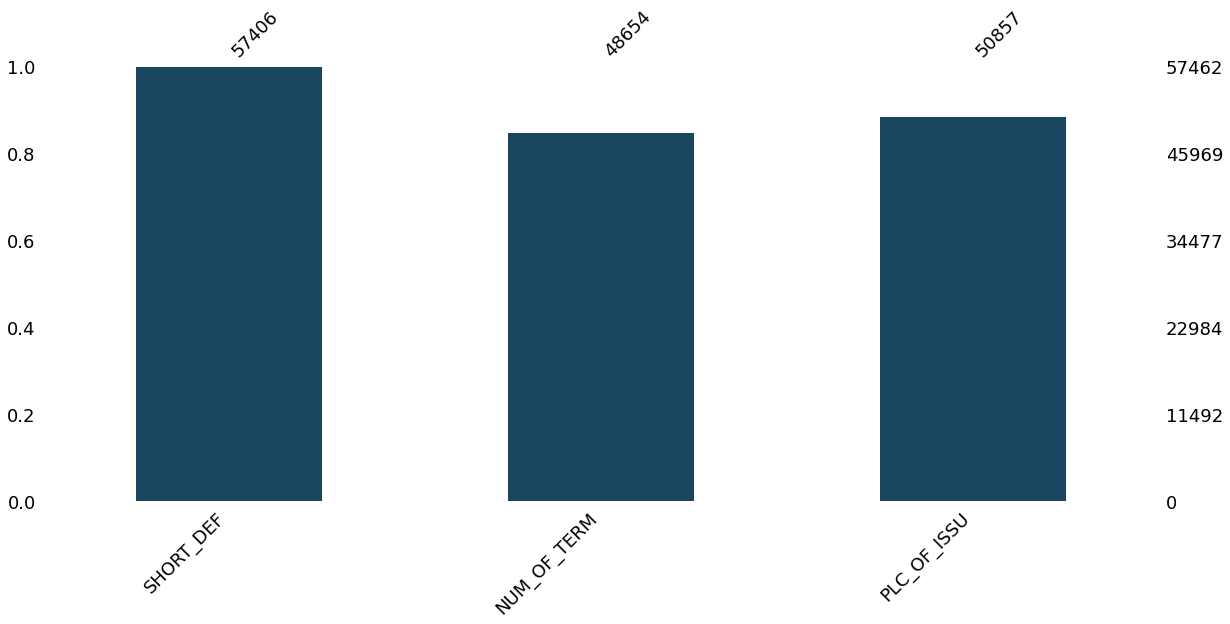

In [ ]:
cols_missing_val = df1.columns[df1.isnull().any()].tolist()
print(cols_missing_val)

msno.bar(df1[cols_missing_val],figsize=(20,8),color="#19455e",fontsize=18,labels=True)

In [ ]:
df1[['SHORT_DEF', 'NUM_OF_TERM', 'PLC_OF_ISSU']].isnull().sum()

SHORT_DEF        56
NUM_OF_TERM    8808
PLC_OF_ISSU    6605
dtype: int64

In [ ]:
MERCHANT_COLUMNS_PROPERTIES.head()

,Unnamed: 0,num_feature
0,0,MER_TYPE
1,1,BRANCH
2,2,CURR_NUM
3,3,DAY_REINSTATED
4,4,DAYS_AVGE


In [ ]:
MERCHANT_COLUMNS_PROPERTIES["num_feature"].to_list()

In [ ]:
list_col_name = MERCHANT_COLUMNS_PROPERTIES["num_feature"].to_list() + ["MERCH_FR"]
df2 = process_data_type(df1)
df = df2[list_col_name].copy()

In [ ]:
numper_of_non_fr = 1500
df_tmp = df[df.MERCH_FR == 0]

df_none_fraud = df_tmp.sample(numper_of_non_fr, random_state=42)
df_sub = df_none_fraud.append(df[df.MERCH_FR == 1], ignore_index = True)
df_sub.shape

(2252, 93)

In [ ]:
df_sub["MERCH_FR"].value_counts()

0    1500
1     752
Name: MERCH_FR, dtype: int64

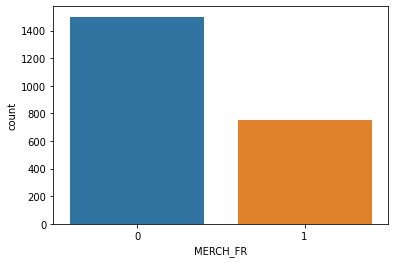

In [ ]:
sns.countplot(df_sub["MERCH_FR"])

# Visualize resample data

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):    
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

In [ ]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [ ]:
# check dtype dataframe 
# dtype_include=object
# num_cols = make_column_selector(dtype_include=np.number)
# object_cols = df_sub.select_dtypes(include='object').columns.to_list()
# num_cols = df_sub.select_dtypes(include='number').columns.to_list()
df_num = df_sub[num_cols]

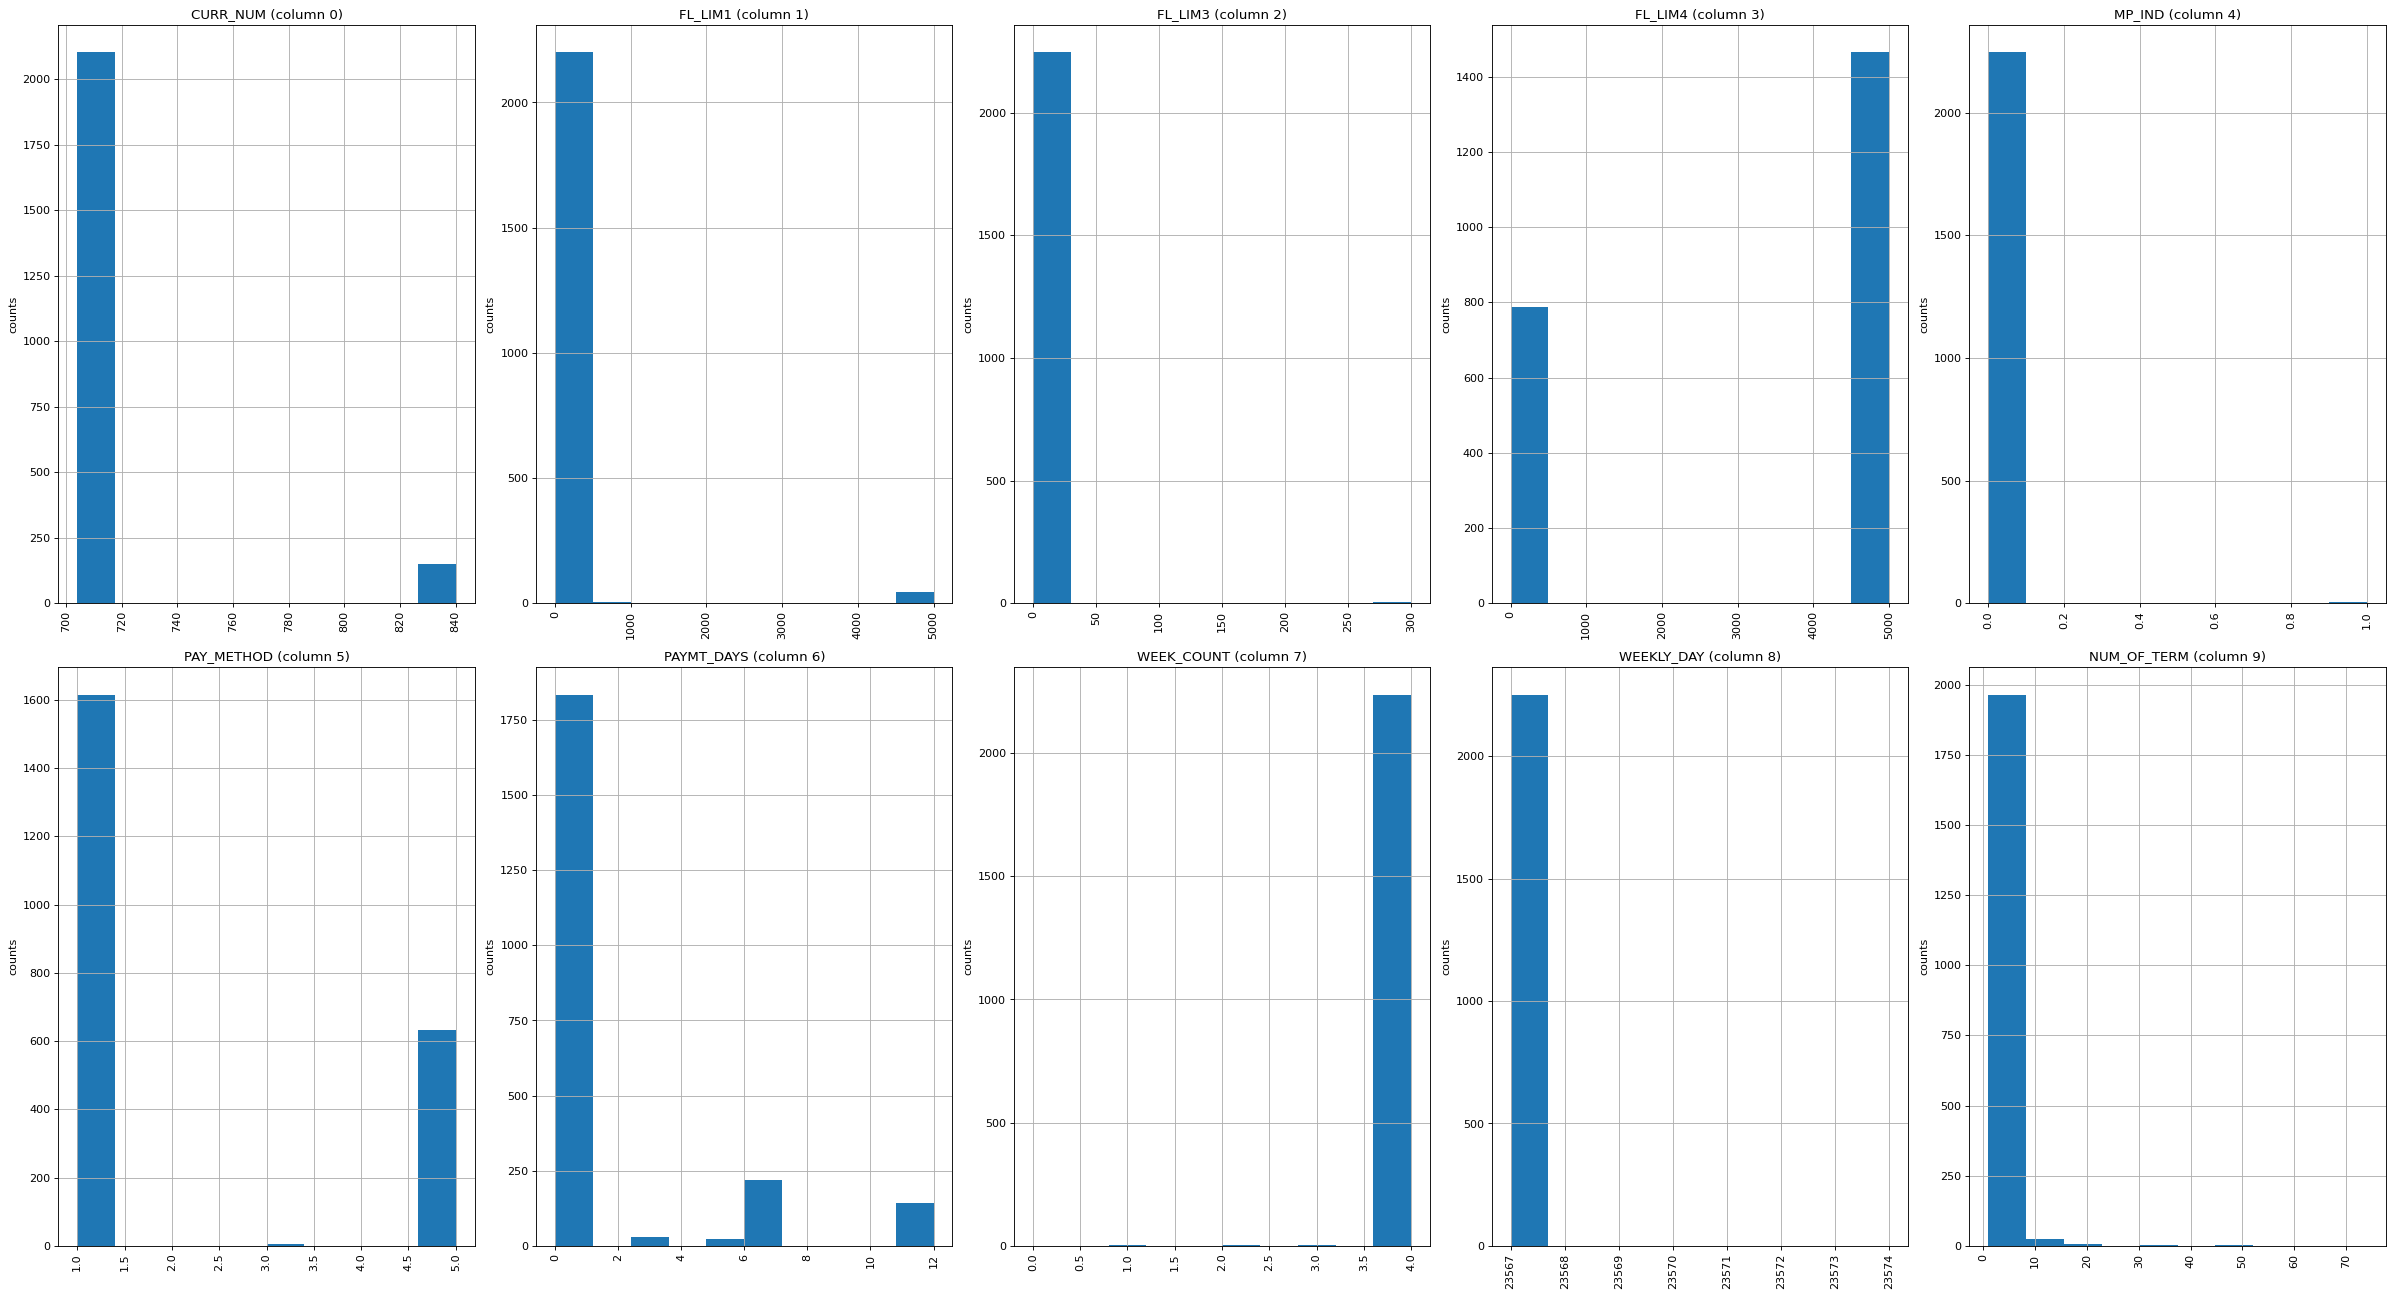

In [ ]:
plotPerColumnDistribution(df_sub, 10, 5)

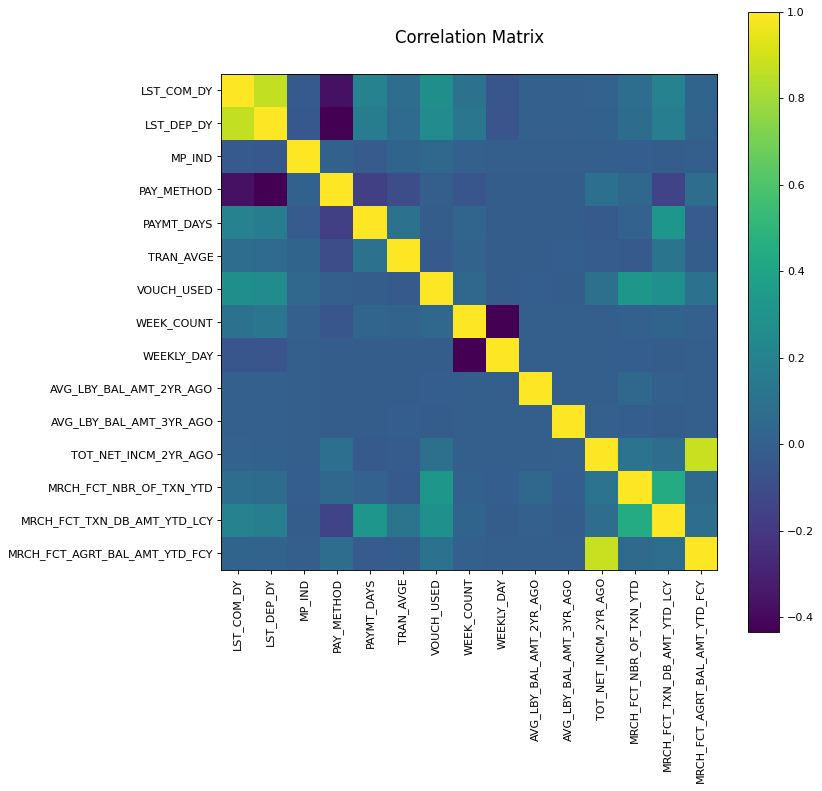

In [ ]:
plotCorrelationMatrix(df_sub.iloc[:, 10:30], 10)

In [ ]:
df_sub.shape

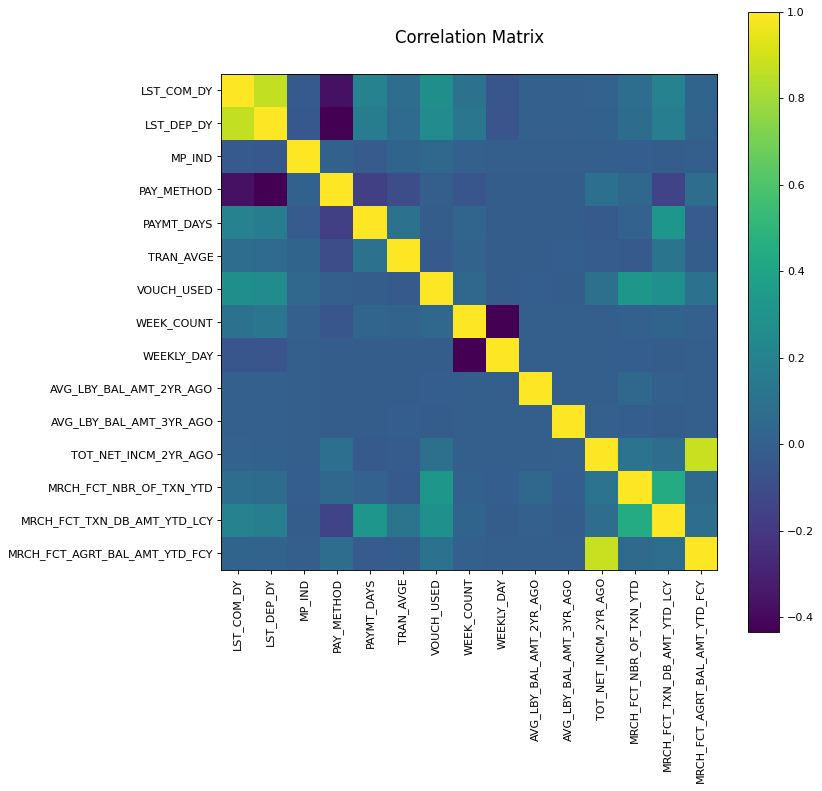

In [ ]:
plotCorrelationMatrix(df_sub.iloc[:, 10:30], 10)

In [ ]:
df_sub.columns[df_sub.isna().any()]

Index(['NUM_OF_TERM'], dtype='object')

In [ ]:
df_fraud = df_sub[df_sub.MERCH_FR == 1].copy()
df_fraud.shape

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline
%load_ext autoreload
%autoreload
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

In [ ]:
columns_ignore = ["DAY_OPEN" ,"DAY_CLOSE" ,"DAY_START" ,"DAY_SUBM" ,"DAY_OPEN_YEAR" ,"DAY_OPEN_MONTH" ,"DAY_OPEN_DAY"  ,"DAY_CLOSE_YEAR" ,"DAY_CLOSE_MONTH" ,"DAY_CLOSE_DAY"  ,"DAY_START_YEAR" ,"DAY_START_MONTH" ,"DAY_START_DAY"  ,"DAY_SUBM_YEAR" ,"DAY_SUBM_MONTH" ,"DAY_SUBM_DAY"]
for col in df_sub.columns:
    if col in columns_ignore:
        continue    
    print('------------------------------------------------------------')
    print(col)

    plt.figure(figsize=(16,4))

    plt.subplot(141)
    sns.distplot(df_fraud[col], label="skew: " + str(np.round(df_fraud[col].skew(),2)))
    plt.title('df_fraud')
    plt.legend()

    plt.subplot(142)
    sns.distplot(df_none_fraud[col], label="skew: " + str(np.round(df_none_fraud[col].skew(),2)))
    plt.title('data none fraud')
    plt.legend()

    plt.subplot(143)
    sns.boxplot(df_fraud[col])
    plt.title('df_fraud')

    plt.subplot(144)
    sns.boxplot(df_none_fraud[col])
    plt.title('data none fraud')
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.